In [1]:
import time
nb_start_time = time.time()

In [2]:
# import libraries
import json
import sys
import os
from tqdm import tqdm
from tqdm import trange
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder

sys.path.append('.')
sys.path.append('../')
sys.path.append('../../')

np.random.seed(42)

In [3]:
# import scripts

import config as config
from scripts.matching import match_behaviors
import src.data_prep.create_segments_and_metadata as create_segments_and_metadata
import src.data_prep.data_prep_utils as data_prep_utils
import src.data_prep.create_matched_data_objects as create_matched_data_objects
import src.utils.data as utils_data
import src.utils.io as utils_io
import src.utils.plot as utils_plot
from src.methods.prediction_model import create_dynamic_conv_model
from src.utils.train import (training_loop,
                             multi_label_eval_loop)
from src.utils.plot import(multi_label_predictions,
                            plot_signal_and_online_predictions)
from src.methods.online_predictions import (online_score_evaluation,
                                            online_smoothening)
from dataclasses import dataclass

In [4]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 30
mpl.rcParams['ytick.labelsize'] = 30
mpl.rcParams["axes.labelsize"] = 30
mpl.rcParams['legend.fontsize'] = 30
mpl.rcParams['axes.titlesize'] = 30
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

## Creating simulated data

We create simulated acceleration and annotations data. We consider five behavioral categories of interest: 
 - Feeding
 - Resting
 - Moving
 - Running
 - Vigilant

Let the tri-axial acceleration at time $t$ for behavior $a$ be denoted by $(X^a(t), Y^a(t), Z^a(t))$. The acceleration signal for each behavior and each direction is simulated using the fourier breakdown of the signal into 5 sets of frequencies, amplitudes, and phase information. Let the (frequency, amplitude, phase) set for $a$ behavior along $X$ axis be denoted by $$(f_{X, i}^a, A_{X,i}^a, \phi_{X, i}^a)_{i=[5]}$$
The sets are defined similarly for other axes and behaviors. Additionally, Gaussian noise with variuance $\sigma_X^2$ (resp. $\sigma_Y^2$ and $\sigma_Z^2$) for X (resp. Y and Z) axisis added to the signal. Therefore, the data is simulated as
$$X^a(t) = \sum_{i=1}^5 A_{X, i}^a \sin(2\pi f_{X,i}^a t + \phi_{X, i}^a) + \mathcal{N}(0, \sigma_X^2).$$


In [5]:
def simulate_fourier_signal(frequencies, amplitudes, phases, n_samples, fs):
    """
    Simulates a signal based on a Fourier breakdown.
    
    Parameters:
    - frequencies: list of frequencies in Hz
    - amplitudes: list of amplitudes
    - phases: list of phase shifts in radians
    - start_time: datetime object
    - end_time: datetime object
    - fs: sampling frequency in Hz
    
    Returns:
    - pd.DataFrame with 'timestamp' and 'signal' columns
    """
    # Check that all input lists are the same length
    if not (len(frequencies) == len(amplitudes) == len(phases)):
        raise ValueError("frequencies, amplitudes, and phases must have the same length")
    
    # Generate time vector

    t = np.linspace(0, n_samples/fs, n_samples, endpoint=False)
    
    # Build signal from the Fourier components
    signal = np.zeros_like(t)
    for f, A, phi in zip(frequencies, amplitudes, phases):
        signal += A * np.sin(2 * np.pi * f * t + phi)
    
    
    return signal

In [6]:
def generate_acc_data(individuals, results_dir, behavior_prob, max_durations, data_constants):
    """
    Simulates and saves synthetic accelerometry data and behavior annotations for multiple individuals over specified years.

    Parameters
    ----------
    individuals : dict
        A dictionary where keys are individual IDs (strings) and values are lists of years (ints) for which to generate data.
        Example: {'Individual1': [2021, 2022], 'Individual2': [2022]}

    results_dir : str
        Path to the output directory where per-individual folders and CSV files will be saved.

    behavior_prob : list of float
        A probability distribution over behaviors (same length and order as `config.BEHAVIORS`) used to randomly sample behaviors during the simulation.

    max_durations: pd.DataFrame
        A DataFrame with columns ['Behavior', 'min', 'sec', where:
            - the min and sec column give the max durstaion in minutes and seconds for each behavior

    data_constants : pd.DataFrame
        A DataFrame with columns ['Behavior', 'Axis', 'f', 'A', 'phi'], where:
            - 'Behavior' is a string (e.g., "Running")
            - 'Axis' is one of "X", "Y", or "Z"
            - 'f', 'A', and 'phi' are lists of floats representing frequencies, amplitudes, and phase shifts for a Fourier signal model of that behavior-axis.

    Returns
    -------
    None
        The function saves two types of files:
        1. Simulated accelerometry CSVs for each individual and year in `results_dir`.
        2. A single annotations CSV at `config.TEST_ANNOTATIONS_PATH` containing all generated behavior labels and their time intervals.
    """

    behavior_data = []

    # generate random accelerometry data for i day
    for individual, years in tqdm(individuals.items()):
        
        individual_dir = os.path.join(results_dir, individual)
        os.makedirs(individual_dir, exist_ok=True)
        
        for year in years:
            start_time = datetime(year, 1, 1)
            end_time = datetime(year, 1, 1, 23, 59, 59)
            current_time = start_time
            time_delta = timedelta(seconds=1/config.SAMPLING_RATE)
            
            timestamps = []
            while current_time <= end_time:
                timestamps.append(current_time)
                current_time += time_delta
            np.random.normal()
            data = {
                "UTC Date[mm/dd]": [t.strftime("%m/%d") for t in timestamps],
                "UTC DateTime": [t.strftime("%H:%M:%S") for t in timestamps],
                "Milliseconds": [t.microsecond // 1000 for t in timestamps],
                "Acc X [g]": np.random.normal(loc=0, scale=0.5, size=len(timestamps)),
                "Acc Y [g]": np.random.normal(loc=0, scale=0.6, size=len(timestamps)),
                "Acc Z [g]": np.random.normal(loc=0, scale=0.3, size=len(timestamps)),
                "Temperature [Celsius]": np.random.uniform(20, 30, len(timestamps))
            }
            
            acc_df = pd.DataFrame(data)

            num_behaviors = np.random.randint(30, 40)
            existing_intervals = []

            attempts = 0
            max_attempts = 500  # prevents infinite loop

            while len(existing_intervals) < num_behaviors and attempts < max_attempts:

                observed_behavior = np.random.choice(a=config.BEHAVIORS,
                                                        p=behavior_prob)

                attempts += 1
                behavior_start = start_time + timedelta(hours=np.random.randint(0, 24), 
                                                        minutes=np.random.randint(0, 60),
                                                        seconds=np.random.randint(5, 120))
                behavior_end = behavior_start + timedelta(minutes=np.random.randint(0, max_durations.loc[observed_behavior, 'min']),
                                                            seconds=np.random.randint(5, max_durations.loc[observed_behavior, 'sec']))

                if behavior_end > end_time:
                    behavior_end = end_time

                overlap = any(
                    not (behavior_end <= existing_start or behavior_start >= existing_end)
                    for (existing_start, existing_end) in existing_intervals
                )
                if overlap:
                    continue  # Skip and try again
                
                existing_intervals.append((behavior_start, behavior_end))
                
                
                behavior_data.append([individual, 
                                    observed_behavior, 
                                    behavior_start.strftime("%Y/%m/%d %H:%M:%S"),
                                    behavior_end.strftime("%Y/%m/%d %H:%M:%S"),
                                    "Video"])
                
                # Modify the acceleration values based on behavior

                df_full_timestamp = pd.to_datetime(str(year) + "/" + acc_df["UTC Date[mm/dd]"] + " " + acc_df["UTC DateTime"], format="%Y/%m/%d %H:%M:%S")
                mask = (df_full_timestamp >= pd.to_datetime(behavior_start, format="%Y/%m/%d %H:%M:%S")) & \
                    (df_full_timestamp <= pd.to_datetime(behavior_end, format="%Y/%m/%d %H:%M:%S"))
                n_samples = acc_df.loc[mask, "Acc X [g]"].shape[0]
                
                f_X, A_X, phi_X = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "X"), ['f', 'A', 'phi']].values[0]
                acc_df.loc[mask, "Acc X [g]"] += simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), n_samples, config.SAMPLING_RATE)

                f_Y, A_Y, phi_Y = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "Y"), ['f', 'A', 'phi']].values[0]
                acc_df.loc[mask, "Acc Y [g]"] += simulate_fourier_signal(list(f_Y), list(A_Y), list(phi_Y), n_samples, config.SAMPLING_RATE)

                f_Z, A_Z, phi_Z = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "Z"), ['f', 'A', 'phi']].values[0]
                acc_df.loc[mask, "Acc Z [g]"] += simulate_fourier_signal(list(f_Z), list(A_Z), list(phi_Z), n_samples, config.SAMPLING_RATE)


            acc_df.to_csv(os.path.join(individual_dir, f"{year}.csv"), index=False)

    # check if annottaions exist already

    annotations_df = pd.DataFrame(behavior_data, 
                                    columns=["id", "Behavior", "Timestamp_start", "Timestamp_end", "Source"])
    annotations_path = os.path.join(results_dir, "test_all_annotations.csv")

    if os.path.exists(annotations_path):
        existing_df = pd.read_csv(annotations_path)
        annotations_df = pd.concat([existing_df, annotations_df], ignore_index=True)
        
    annotations_df.to_csv(annotations_path, index=False)



In [7]:
#############################################
###### Training & Saving 
##############################################

def train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device):

    epochs = args.num_epochs

    avg_train_losses, avg_test_losses = [], []
    best_val_loss = 100
    training_stats = []

    start_time = time.time()

    progress_bar = trange(epochs, desc="Initializing...")

    for epoch in progress_bar:

        model.train()

        t0 = time.time()

        total_train_loss = training_loop(model, optimizer, criterion, train_dataloader, device=device)

        t1 = time.time()

        with torch.no_grad():
            val_loss, val_true_classes, val_predictions, val_scores = multi_label_eval_loop(model, criterion, val_dataloader, device=device)

        t2 = time.time()
        
        if val_loss < best_val_loss:

            # calculate test scores
            with torch.no_grad():
                test_loss, test_true_classes, test_predictions, test_scores = multi_label_eval_loop(model, criterion, test_dataloader, device=device)

            best_val_loss, best_val_predictions, best_val_scores = val_loss, val_predictions, val_scores
        
        # save train and test loss every 10 epochs 
        
        avg_train_loss = total_train_loss/len(train_dataloader)
        avg_train_losses.append(avg_train_loss)
        avg_test_losses.append(val_loss)

        progress_bar.set_description(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {val_loss:.4f}")


        if args.verbose and (epoch == 0 or (epoch+1)%10 == 0):
            print("")
            print(f'========= Epoch {epoch+1}/{epochs} ==========')
            print(f"Average train loss: {avg_train_loss}")
            print(f" Average val loss: {val_loss}")    
            print(f" Best val loss: {best_val_loss}, best test loss: {test_loss}")   

        training_stats.append(
        {
            "epoch": epoch + 1,
            "Training Loss": avg_train_loss,
            "Validation Loss": val_loss,
            "Training Time": utils_io.format_time(t1 - t0),
            "Validation Time": utils_io.format_time(t2 - t1),
        }
        ) 

    end_time = time.time()
    print("")
    print("=======================")
    print(f'Total training time: {utils_io.format_time(end_time-start_time)}')   

    return {'model': model,
            'training_stats': training_stats,
            'test_true_classes': test_true_classes,
            'test_predictions': test_predictions,
            'test_scores': test_scores,
            'val_true_classes': val_true_classes,
            'val_predictions': val_predictions,
            'val_scores': val_scores
            } 


In [8]:
data_constants = [
    # Resting — make it slightly jittery to overlap with Vigilant
    ("Resting", "X", (0.2, 0.3, 0.4), (0.1, 0.15, 0.2), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),
    ("Resting", "Y", (0.2, 0.3, 0.4), (0.1, 0.15, 0.2), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),
    ("Resting", "Z", (0.2, 0.3, 0.4), (0.1, 0.15, 0.2), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),

    # Vigilant — lower the amplitude and raise noise to blur with Resting
    ("Vigilant", "X", (0.3, 0.5, 0.8), (0.2, 0.3, 0.4), (0.0, 0.3, 0.6), (0.2, 0.25, 0.3)),
    ("Vigilant", "Y", (0.4, 0.6, 0.9), (0.3, 0.4, 0.5), (0.0, 0.4, 0.8), (0.2, 0.25, 0.3)),
    ("Vigilant", "Z", (0.4, 0.6, 1.0), (0.3, 0.5, 0.6), (0.0, 0.5, 1.0), (0.2, 0.25, 0.3)),

    # Feeding — bring down the amplitude and overlap with Moving
    ("Feeding", "X", (1.8, 2.5, 3.2), (1.5, 1.8, 2.1), (0.2, 0.7, 1.2), (0.3, 0.35, 0.4)),
    ("Feeding", "Y", (2.0, 2.8, 3.5), (1.6, 1.9, 2.2), (0.3, 0.8, 1.3), (0.3, 0.35, 0.4)),
    ("Feeding", "Z", (2.2, 2.9, 3.7), (1.7, 2.0, 2.3), (0.4, 0.9, 1.4), (0.3, 0.35, 0.4)),

    # Moving — slightly reduce amplitude, overlap more with Feeding
    ("Moving", "X", (2.5, 3.2, 4.0), (2.0, 2.3, 2.5), (0.6, 1.2, 1.8), (0.35, 0.4, 0.45)),
    ("Moving", "Y", (2.8, 3.5, 4.2), (2.1, 2.4, 2.6), (0.5, 1.0, 1.5), (0.35, 0.4, 0.45)),
    ("Moving", "Z", (3.0, 3.8, 4.5), (2.0, 2.5, 2.7), (0.7, 1.2, 1.8), (0.35, 0.4, 0.45)),

    # Running — keep it distinct, but increase overlap with upper Moving
    ("Running", "X", (4.5, 5.5, 6.5), (3.8, 4.2, 4.5), (0.6, 1.0, 1.4), (0.4, 0.5, 0.6)),
    ("Running", "Y", (5.0, 6.0, 7.0), (3.5, 4.0, 4.5), (0.4, 0.9, 1.5), (0.4, 0.5, 0.6)),
    ("Running", "Z", (5.5, 6.5, 7.5), (3.8, 4.3, 5.0), (0.7, 1.1, 1.6), (0.4, 0.5, 0.6)),
]

data_constants = pd.DataFrame(data_constants, columns=[
    "Behavior", "Axis", "f", "A", "phi", "sigma"
])


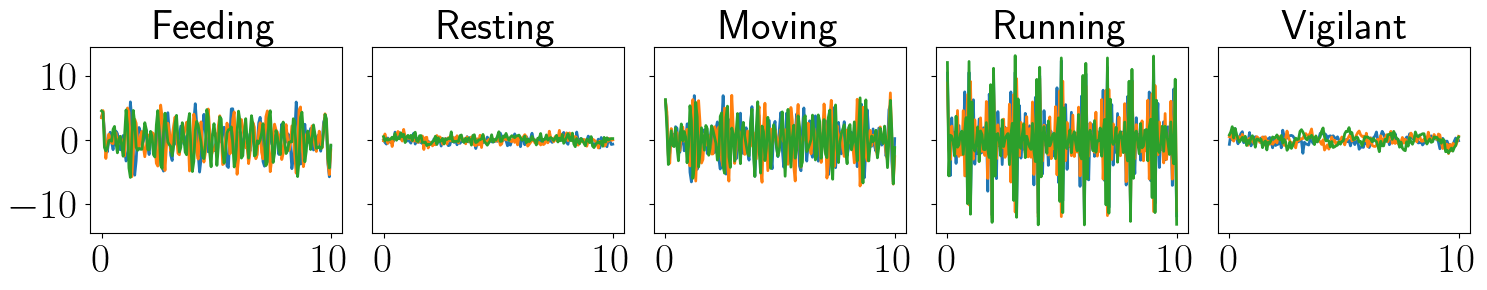

In [9]:
t = np.linspace(0, 10, 160)
fig, axs = plt.subplots(1, 5, figsize=(15,3), sharey=True)
for i, observed_behavior in enumerate(config.BEHAVIORS):
    f_X, A_X, phi_X = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "X"), ['f', 'A', 'phi']].values[0]
    f_Y, A_Y, phi_Y = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "Y"), ['f', 'A', 'phi']].values[0]
    f_Z, A_Z, phi_Z = data_constants.loc[(data_constants["Behavior"] == observed_behavior) & (data_constants["Axis"] == "Z"), ['f', 'A', 'phi']].values[0]

    signal_x = simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE)+np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_y = simulate_fourier_signal(list(f_Y), list(A_Y), list(phi_Y), len(t), config.SAMPLING_RATE)+np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_z = simulate_fourier_signal(list(f_Z), list(A_Z), list(phi_Z), len(t), config.SAMPLING_RATE)+np.random.normal(loc=0, scale=0.5, size=len(t))

    axs[i].plot(t, signal_x)
    axs[i].plot(t, signal_y)
    axs[i].plot(t, signal_z)
    axs[i].set_title(observed_behavior)

plt.tight_layout()
plt.show()



## Result 1: Class Imbalance

We simulate data with extreme class imabalance. We assume the following class distribution for the behaviors of interest.


| Behavior | Probability of occurence |
|----------|--------------------------|
| Feeding  |  0.05   |
| Resting  | 0.5 |
| Moving   | 0.2 |
| Running  | 0.05 |
| Vigilant | 0.2 |




In [10]:
# Define individuals and years of dataset available for them
individuals = {"individual1": [2022],
               "individual2": [2022, 2023],
               "individual3": [2023],
               "individual4": [2022],
               "individual5": [2023]}

behavior_prob = [0.05, 0.5, 0.2, 0.05, 0.2]

max_durations = {
    "Feeding": {"min": 1, "sec": 60},
    "Resting": {"min": 3, "sec": 60},
    "Moving": {"min": 2, "sec": 60},
    "Running": {"min": 1, "sec": 60},
    "Vigilant": {"min": 3, "sec": 60}
}

# Convert to DataFrame
max_durations = pd.DataFrame.from_dict(max_durations, orient="index")
max_durations.index.name = "Behavior"
max_durations.columns.name = "DurationUnit"

print("CLASS DISTRIBUTION")
for b, p in zip(config.BEHAVIORS, behavior_prob):
    print(f"{b:<10}: {p}")

# Create directories and generate acceleration data
os.makedirs(config.TEST_ROOT_DIR, exist_ok=True)
results_dir = os.path.join(config.TEST_ROOT_DIR, "class_imbalance")
os.makedirs(results_dir, exist_ok=True)

# define paths for various objects for this result subsection
annotations_path = results_dir+"/test_all_annotations.csv"
metadata_path = results_dir+"/test_metadata.csv"
data_path = os.path.join(results_dir, "data")
os.makedirs(data_path, exist_ok=True)
training_results_dir = os.path.join(results_dir, "training_results")
os.makedirs(training_results_dir, exist_ok=True)

matched_summary_path = data_path+"/matched_acc_summary.csv"
matched_data_path = data_path+"/matched_acc_data.csv"
matched_metadata_path = data_path+"/matched_acc_metadata.csv"


CLASS DISTRIBUTION
Feeding   : 0.05
Resting   : 0.5
Moving    : 0.2
Running   : 0.05
Vigilant  : 0.2


In [87]:
generate_acc_data(individuals, results_dir, behavior_prob, max_durations=max_durations, data_constants=data_constants)

100%|██████████| 5/5 [02:37<00:00, 31.47s/it]


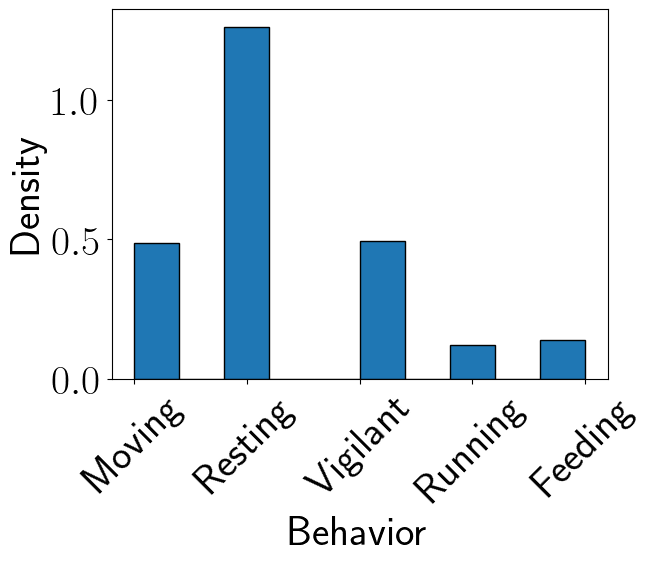

In [88]:
annotations_df = pd.read_csv(annotations_path)
plt.hist(annotations_df['Behavior'], edgecolor='black', density=True)
plt.xticks(rotation=45) 
plt.xlabel("Behavior")  # Label x-axis
plt.ylabel("Density")  # Label y-axis
plt.show()

In [89]:
individuals = [f"individual{i}" for i in range(1, 6)]
test_paths = {ind: f"{results_dir}/{ind}" for ind in individuals}

# create halfday segments
create_segments_and_metadata.run_vectronics(test_paths, max_chunks=5)

# create metadata
create_segments_and_metadata.create_metadata(test_paths, metadata_path)

Processing individual:         individual1
Files for this individual :    ['2022.csv']
Handling the csv:              /home/medhaaga/AWD-Biologging/test/class_imbalance/individual1/2022.csv

Processing individual:         individual2
Files for this individual :    ['2023.csv', '2022.csv']
Handling the csv:              /home/medhaaga/AWD-Biologging/test/class_imbalance/individual2/2023.csv
Handling the csv:              /home/medhaaga/AWD-Biologging/test/class_imbalance/individual2/2022.csv

Processing individual:         individual3
Files for this individual :    ['2023.csv']
Handling the csv:              /home/medhaaga/AWD-Biologging/test/class_imbalance/individual3/2023.csv

Processing individual:         individual4
Files for this individual :    ['2022.csv']
Handling the csv:              /home/medhaaga/AWD-Biologging/test/class_imbalance/individual4/2022.csv

Processing individual:         individual5
Files for this individual :    ['2023.csv']
Handling the csv:              /ho

100%|██████████| 2/2 [00:14<00:00,  7.06s/it]


individual individual2 has 4 halfdays.


100%|██████████| 4/4 [00:28<00:00,  7.07s/it]


individual individual3 has 2 halfdays.


100%|██████████| 2/2 [00:14<00:00,  7.07s/it]


individual individual4 has 2 halfdays.


100%|██████████| 2/2 [00:14<00:00,  7.01s/it]


individual individual5 has 2 halfdays.


100%|██████████| 2/2 [00:14<00:00,  7.02s/it]


In [90]:
# load metadata and annotations
metadata = pd.read_csv(metadata_path)
all_annotations = pd.read_csv(annotations_path)

acc_summary, acc_data, acc_data_metadata = create_matched_data_objects.create_matched_data(metadata, all_annotations)

# save the matched data objects 
acc_summary.to_csv(matched_summary_path)
acc_data.to_csv(matched_data_path)
acc_data_metadata.to_csv(matched_metadata_path)

individual individual1 has 2 halfdays in the filtered metadata.


Processing unique half days for individual1: 100%|██████████| 2/2 [00:19<00:00,  9.83s/it]


individual individual2 has 4 halfdays in the filtered metadata.


Processing unique half days for individual2: 100%|██████████| 4/4 [00:39<00:00,  9.99s/it]


individual individual3 has 2 halfdays in the filtered metadata.


Processing unique half days for individual3: 100%|██████████| 2/2 [00:18<00:00,  9.03s/it]


individual individual4 has 2 halfdays in the filtered metadata.


Processing unique half days for individual4: 100%|██████████| 2/2 [00:18<00:00,  9.15s/it]


individual individual5 has 2 halfdays in the filtered metadata.


Processing unique half days for individual5: 100%|██████████| 2/2 [00:19<00:00,  9.50s/it]


In [11]:
# load metadata and annotations
metadata = pd.read_csv(metadata_path)
all_annotations = pd.read_csv(annotations_path)

# load the saved matched data objects 
acc_summary = pd.read_csv(matched_summary_path)
acc_data = pd.read_csv(matched_data_path)
acc_data_metadata = pd.read_csv(matched_metadata_path)

In [12]:
train_filter_profile, test_filter_profile = utils_data.get_exp_filter_profiles('no_split')
print('NO SPLIT')
print(f"{'train filter':<15} {train_filter_profile}")
print(f"{'test filter':<15} {test_filter_profile}")

NO SPLIT
train filter    {'individual ID': None, 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}
test filter     {'individual ID': None, 'year': None, 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}


In [13]:
@dataclass
class Arguments:
    experiment_name: str
    batch_size: int
    window_duration_percentile: float
    train_test_split: float
    train_val_split: float
    padding: str
    theta: float
    filter_type: str
    cutoff_frequency: float
    cutoff_order: int
    normalization: int
    match: int
    min_duration: float
    n_CNNlayers: int
    n_channels: int
    kernel_size: int
    learning_rate: float
    weight_decay: float
    num_epochs: int
    alpha: float
    verbose: int

args = Arguments(
    experiment_name='no_split', batch_size=64, window_duration_percentile=20, 
    train_test_split=0.2, train_val_split=0.2, padding='repeat', theta=0.0, 
    filter_type='high', cutoff_frequency=0, cutoff_order=5, normalization=0,
    match=0, min_duration=1.0, n_CNNlayers=3, n_channels=16, kernel_size=5,
    learning_rate=0.0001, weight_decay=0.0001, num_epochs=500, alpha=0.05, verbose=0
)


In [14]:
start = time.time()
X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, _ = utils_data.setup_data_objects(metadata=metadata, 
                                                                                                    all_annotations=all_annotations, 
                                                                                                    collapse_behavior_mapping=config.COLLAPSE_BEHAVIORS_MAPPING, 
                                                                                                    behaviors=config.BEHAVIORS, 
                                                                                                    args=args, 
                                                                                                    reuse_behaviors=config.BEHAVIORS,
                                                                                                    acc_data_path=matched_data_path,
                                                                                                    acc_metadata_path=matched_metadata_path
                                                                                                    )
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(np.concatenate((y_train, y_val, y_test))))

print("Train Class distribution")
print("==========================")
print(pd.DataFrame(np.unique(y_train, return_counts=True)[1]))
print("")

time_diff = time.time() - start

print("")
print(f'Creating data objects takes {time_diff:.2f} seconds.')
print("")
print("Shape of dataframes")
print("==========================")
print(f"{'Set':<8} {'X':<15} {'Y':<10} {'Z':<15}")
print(f"{'Train:':<8} {str(X_train.shape):<15} {str(y_train.shape):<10} {str(z_train.shape):<15}")
print(f"{'Val:':<8} {str(X_val.shape):<15} {str(y_val.shape):<10} {str(z_val.shape):<15}")
print(f"{'Test:':<8} {str(X_test.shape):<15} {str(y_test.shape):<10} {str(z_test.shape):<15}")

Using pre-matched acceleration-behavior pairs...
Total number of matched annotations: 205
Before overlap, 
no. of train observations: 205, no. of test observations: 205
Overlapping indices of shape = (205,)
After removing overlaps, 
no. of train observations: 164, no. of test observations: 41

Matching annotations to acceleration snippets takes 32.291113 seconds


/home/medhaaga/AWD-Biologging/notebooks/../src/utils/data.py:318: UserWarning: train and test filters overlap
  warnings.warn("train and test filters overlap", UserWarning)


Creating fixed-duration windows takes 3.929562 seconds.

Time series duration window = 32.0
Train Class distribution
      0
0    55
1   338
2  1351
3    74
4   589


Creating data objects takes 36.39 seconds.

Shape of dataframes
Set      X               Y          Z              
Train:   (2407, 3, 512)  (2407,)    (2407, 7)      
Val:     (602, 3, 512)   (602,)     (602, 7)       
Test:    (779, 3, 512)   (779,)     (779, 7)       


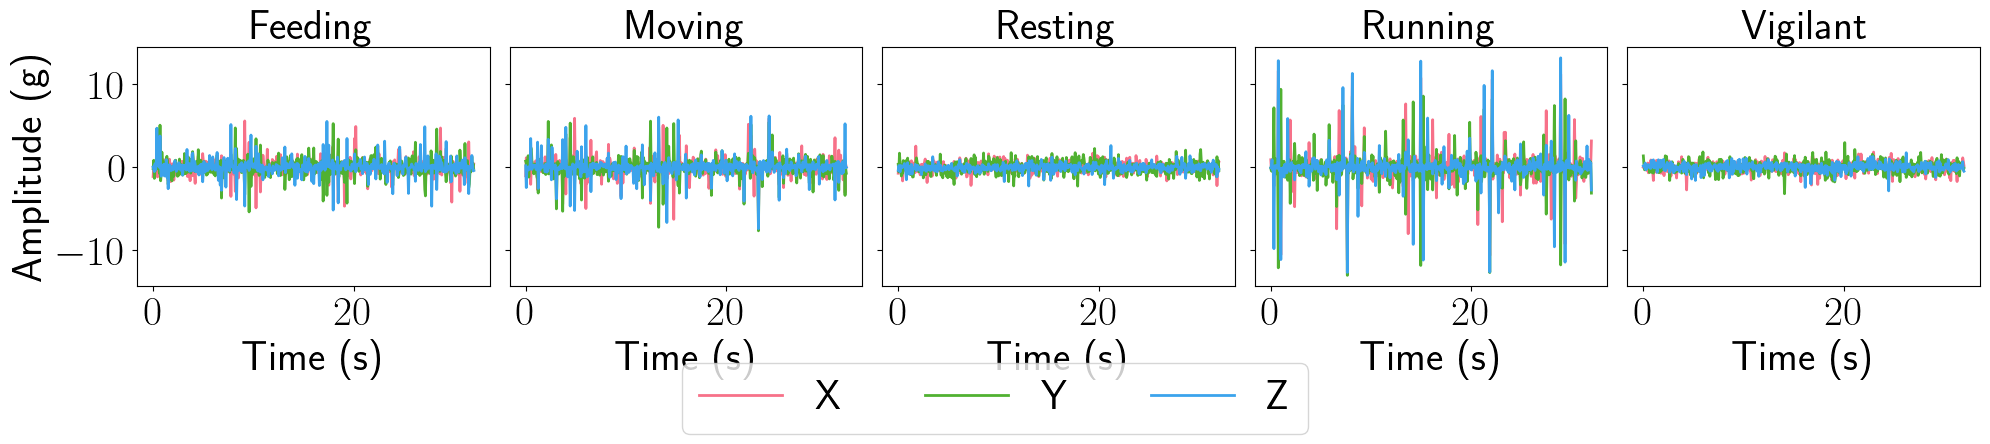

In [15]:
## fit a label encoder

label_encoder = LabelEncoder()
label_encoder.fit(config.BEHAVIORS)
utils_plot.plot_raw_time_series(X_train, label_encoder.inverse_transform(y_train))

In [ ]:
thetas = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

for theta in thetas:

    args.theta = theta

    #########################################
    #### Dataloaders
    #########################################

    train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)

    #########################################
    #### Model, loss, and optimizer
    #########################################

    device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

    # Define the sequential model
    model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                        num_conv_layers=args.n_CNNlayers, 
                                        base_channels=args.n_channels, 
                                        kernel_size=args.kernel_size).to(device)

    print("")
    print("==================================")
    print(f"Number of trainable model paramters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

    # Loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

    #########################################
    #### Training
    #########################################

    train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device)
    model = train_obj['model']
    training_stats = train_obj['training_stats']

    dir = os.path.join(training_results_dir, f"theta{args.theta}")
    os.makedirs(dir, exist_ok=True)
    torch.save(model, os.path.join(dir, 'model.pt'))
    json_training_stats_file = os.path.join(dir, 'training_stats.json')
    with open(json_training_stats_file, 'w') as f:
        json.dump(training_stats, f)

    
    # save true and predicted test classes along with test metadata
    np.save(os.path.join(dir, 'test_true_classes.npy'), train_obj['test_true_classes'])
    np.save(os.path.join(dir, 'test_predictions.npy'),  train_obj['test_predictions'])
    np.save(os.path.join(dir, 'test_scores.npy'),  train_obj['test_scores'])

    # save true and predicted validation classes along with val metadata
    np.save(os.path.join(dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
    np.save(os.path.join(dir, 'val_predictions.npy'),  train_obj['val_predictions'])
    np.save(os.path.join(dir, 'val_scores.npy'),  train_obj['val_scores'])



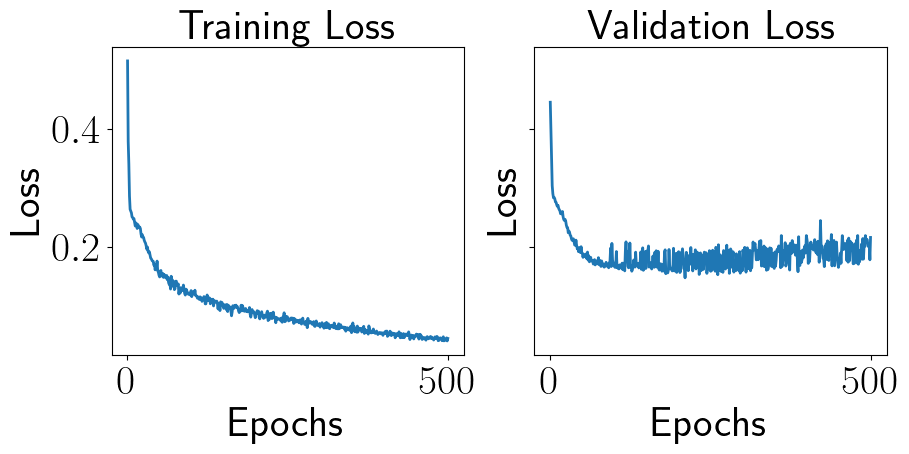

In [ ]:
#plot training stats
training_stats = pd.DataFrame(training_stats)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(training_stats['epoch'], training_stats['Training Loss'])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(training_stats['epoch'], training_stats['Validation Loss'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Validation Loss")
plt.show()

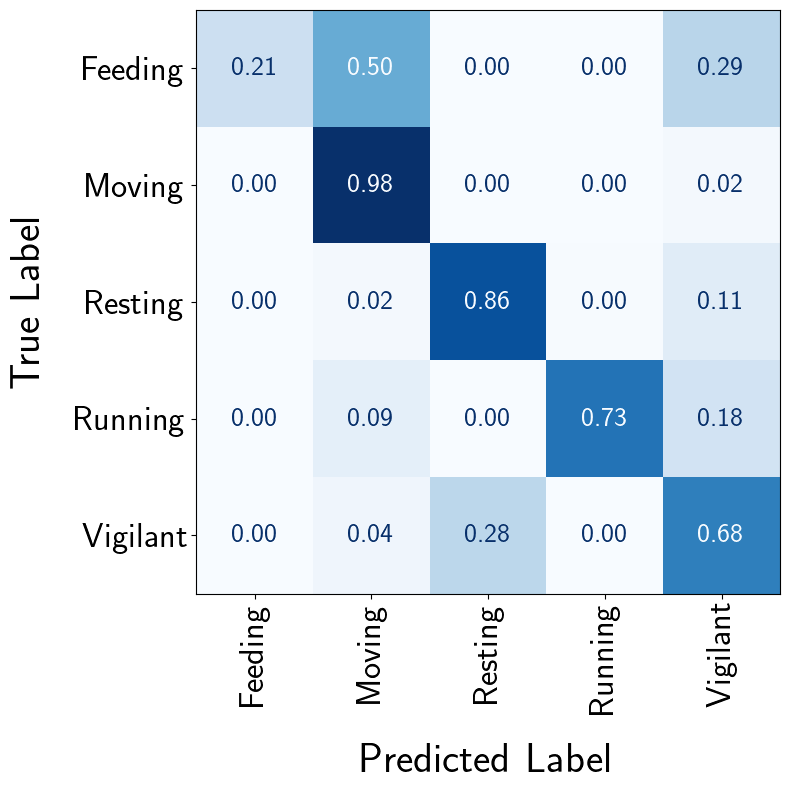

In [ ]:
dir = os.path.join(training_results_dir, f"theta0.0")
y= np.load(os.path.join(dir, 'test_true_classes.npy'))
y_hat= np.load(os.path.join(dir, 'test_predictions.npy'))

multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=None)

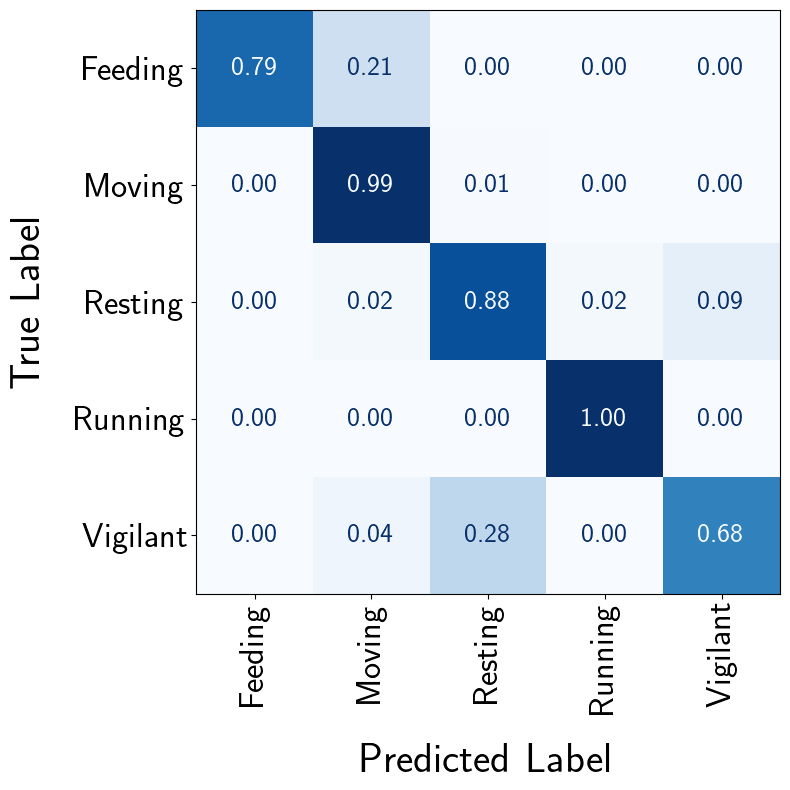

In [ ]:
dir = os.path.join(training_results_dir, f"theta0.8")
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=None)

## Result 1: Uncertainty Quantification

We simulate data with extreme class imabalance. We assume the following class distribution for the behaviors of interest.


In [17]:
from src.methods.conformal_prediction import *
from src.utils.conformal import *

dir = os.path.join(training_results_dir, f"theta0.0")
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")
model = torch.load(os.path.join(dir, 'model.pt'))
cdataloader = DataLoader(TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val)), batch_size=args.batch_size, shuffle=False)
cmodel = ConformalModel(model, cdataloader, alpha=0.05, lamda_criterion='size').to(device)
torch.save(cmodel, os.path.join(dir, 'cmodel.pt'))

/tmp/ipykernel_3151448/1255588465.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(dir, 'model.pt'))


Begin Platt scaling.
Computing logits for model (only happens once).


100%|██████████| 10/10 [00:00<00:00, 501.69it/s]


Optimal T=0.9482303261756897


In [18]:
test_scores = np.load(os.path.join(dir, 'test_scores.npy'))
for observed_behavior in config.BEHAVIORS:
    print(observed_behavior)
    label = label_encoder.transform([observed_behavior])
    mask = (y_test == label)
    ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[mask], dtype=torch.float32), torch.tensor(y_test[mask])), batch_size=args.batch_size, shuffle=False)
    no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

    

Feeding
N: 14 | Avg Time: 0.009 | Avg Cvg@1: 0.429 | Avg Cvg@K: 0.643 | Avg Cvg@RAPS: 0.643 | Avg Size@RAPS: 2.000

Resting
N: 429 | Avg Time: 0.004 | Avg Cvg@1: 0.937 | Avg Cvg@K: 0.965 | Avg Cvg@RAPS: 0.958 | Avg Size@RAPS: 1.709

Moving
N: 129 | Avg Time: 0.004 | Avg Cvg@1: 0.992 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 1.000 | Avg Size@RAPS: 1.705

Running
N: 11 | Avg Time: 0.004 | Avg Cvg@1: 1.000 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 1.000 | Avg Size@RAPS: 1.909

Vigilant
N: 196 | Avg Time: 0.003 | Avg Cvg@1: 0.490 | Avg Cvg@K: 0.964 | Avg Cvg@RAPS: 0.898 | Avg Size@RAPS: 1.857



In [19]:
mask = (np.max(test_scores, axis=1) < 0.5)
print(len(mask))

# test observations with high score
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[mask], dtype=torch.float32), torch.tensor(y_test[mask])), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

# test observations with low score
ctestdataloader = DataLoader(TensorDataset(torch.tensor(X_test[1-mask], dtype=torch.float32), torch.tensor(y_test[1-mask])), batch_size=args.batch_size, shuffle=False)
no_split_test_top1, no_split_test_topK, no_split_test_coverage, no_split_test_size = validate(ctestdataloader, cmodel, print_bool=True, topk=(1,2))

779
N: 36 | Avg Time: 0.008 | Avg Cvg@1: 0.556 | Avg Cvg@K: 0.889 | Avg Cvg@RAPS: 0.889 | Avg Size@RAPS: 2.056

N: 779 | Avg Time: 0.003 | Avg Cvg@1: 1.000 | Avg Cvg@K: 1.000 | Avg Cvg@RAPS: 1.000 | Avg Size@RAPS: 1.685



## Result 3: Temporal Context

In [20]:
def simulate_markov_acc_day(data_constants, transition_matrix, avg_durations):
    """
    Simulate a half-day of tri-axial acceleration data using a Markov process 
    to determine behavior transitions.

    Parameters
    ----------
    data_constants : pd.DataFrame
        A DataFrame containing the Fourier signal parameters (`f`, `A`, `phi`)
        for each behavior and axis ('X', 'Y', 'Z'). It must have columns:
        'Behavior', 'Axis', 'f', 'A', 'phi'.
    
    transition_matrix : np.ndarray
        A square Markov transition matrix of shape (B, B), where B is the number behaviors.

    avg_durations : pd.DataFrame
        A DataFrame with average durations for each behavior. It must have the behavior as index 
        and columns ['min', 'sec'] specifying the mean duration in minutes and seconds.

    Returns
    -------
    acc_df : pd.DataFrame
        A DataFrame containing the simulated accelerometer data with columns:
        ['Timestamp', 'Acc X [g]', 'Acc Y [g]', 'Acc Z [g]', 'Temperature [Celsius]', 'Behavior'].

    annotations_df : pd.DataFrame
        A DataFrame with behavior annotations corresponding to segments of the 
        generated signal. Columns include:
        ['id', 'Behavior', 'Timestamp_start', 'Timestamp_end', 'Source'].
    """
    
    start_time = datetime(2023, 1, 1, 0, 0, 0)
    end_time = datetime(2023, 1, 1, 12, 0, 0)
    current_time = start_time

    behaviors = config.BEHAVIORS
    behavior_to_index = {b: i for i, b in enumerate(behaviors)}
    index_to_behavior = {i: b for b, i in behavior_to_index.items()}
    
    current_behavior = np.random.choice(behaviors)
    acc_data = []
    behavior_annotations = []

    while current_time < end_time:
        # Sample duration (e.g., 30–300 seconds)
        
        duration = timedelta(minutes=np.random.normal(loc=avg_durations.loc[current_behavior, 'min'], scale=1, size=1).item(),
                             seconds=np.random.normal(loc=avg_durations.loc[current_behavior, 'sec'], scale=1, size=1).item())
        segment_end = min(current_time + duration, end_time)
        n_samples = int((segment_end - current_time).total_seconds() * config.SAMPLING_RATE)

        timestamps = [current_time + timedelta(seconds=i/config.SAMPLING_RATE) for i in range(n_samples)]

        # Retrieve Fourier params for current behavior
        def get_signal(axis):
            f, A, phi = data_constants.loc[
                (data_constants["Behavior"] == current_behavior) & 
                (data_constants["Axis"] == axis), ['f', 'A', 'phi']
            ].values[0]
            return simulate_fourier_signal(list(f), list(A), list(phi), n_samples, config.SAMPLING_RATE)
        
        acc_x = get_signal("X") + np.random.normal(0, 0.5, n_samples)
        acc_y = get_signal("Y") + np.random.normal(0, 0.6, n_samples)
        acc_z = get_signal("Z") + np.random.normal(0, 0.3, n_samples)

        for i in range(n_samples):
            acc_data.append({
                "Timestamp": timestamps[i],
                "Acc X [g]": acc_x[i],
                "Acc Y [g]": acc_y[i],
                "Acc Z [g]": acc_z[i],
                "Temperature [Celsius]": np.random.uniform(20, 30),
                "Behavior": current_behavior
            })

        # Record annotation
        behavior_annotations.append([
            "Individual1",
            current_behavior,
            current_time.strftime("%Y-%m-%d %H:%M:%S"),
            segment_end.strftime("%Y-%m-%d %H:%M:%S"),
            "Markov"
        ])

        # Transition to next behavior
        current_index = behavior_to_index[current_behavior]
        current_behavior = np.random.choice(behaviors, p=transition_matrix[current_index])

        current_time = segment_end

    acc_df = pd.DataFrame(acc_data)
    annotations_df = pd.DataFrame(behavior_annotations, columns=["id", "Behavior", "Timestamp_start", "Timestamp_end", "Source"])
    return acc_df, annotations_df


In [21]:
results_dir = os.path.join(config.TEST_ROOT_DIR, "temporal_context")
os.makedirs(results_dir, exist_ok=True)

avg_durations = {
    "Feeding": {"min": 10, "sec": 60},
    "Resting": {"min": 30, "sec": 60},
    "Moving": {"min": 20, "sec": 60},
    "Running": {"min": 5, "sec": 60},
    "Vigilant": {"min": 15, "sec": 60}
}

# Convert to DataFrame
avg_durations = pd.DataFrame.from_dict(avg_durations, orient="index")
avg_durations.index.name = "Behavior"
avg_durations.columns.name = "DurationUnit"

transition_matrix = np.array([
    [0.4, 0.0, 0.3, 0.2, 0.1],  # from Feeding
    [0.0, 0.5, 0.2, 0.1, 0.2],  # from Resting
    [0.1, 0.3, 0.3, 0.2, 0.1],  # from Moving
    [0.2, 0.0, 0.3, 0.4, 0.1],  # from Running
    [0.0, 0.3, 0.2, 0.1, 0.4]   # from Vigilant
])

# Turn into DataFrame for readability
transition_df = pd.DataFrame(transition_matrix, index=config.BEHAVIORS, columns=config.BEHAVIORS)


In [22]:
acc_df, annotations_df = simulate_markov_acc_day(data_constants, transition_matrix, avg_durations)

In [31]:
window_duration = 32.0
model_dir = os.path.join(training_results_dir, f"theta0.0")

In [32]:
smoothening_config = {'smoothening_window_length': 100,
                          'smoothening_hop_length': 10,
                          'score_hop_length': None
                          }

acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
acc_df.sort_values(by='Timestamp', inplace=True)
signal = torch.tensor(np.array([acc_df['Acc X [g]'].values, acc_df['Acc Y [g]'].values, acc_df['Acc Z [g]'].values])).float().unsqueeze(0)
scores = online_score_evaluation(model_dir=model_dir, X=signal, window_duration=window_duration, window_length=None, hop_length=smoothening_config['score_hop_length'], sampling_frequency=config.SAMPLING_RATE)
online_avg = online_smoothening(scores, smoothening_config['smoothening_window_length'], smoothening_config['smoothening_hop_length'])


/home/medhaaga/AWD-Biologging/notebooks/../src/methods/online_predictions.py:31: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cmodel = torch.load(os.path.join(model_dir, 'c

In [33]:
label_encoder = LabelEncoder()
label_encoder.fit(config.BEHAVIORS)
half_day_behaviors = annotations_df
half_day_behaviors = half_day_behaviors.rename(columns={'Timestamp_start': 'behavior_start', 'Timestamp_end': 'behavior_end', 'Behavior': 'behavior'})

/tmp/ipykernel_3151448/2370695748.py:43: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


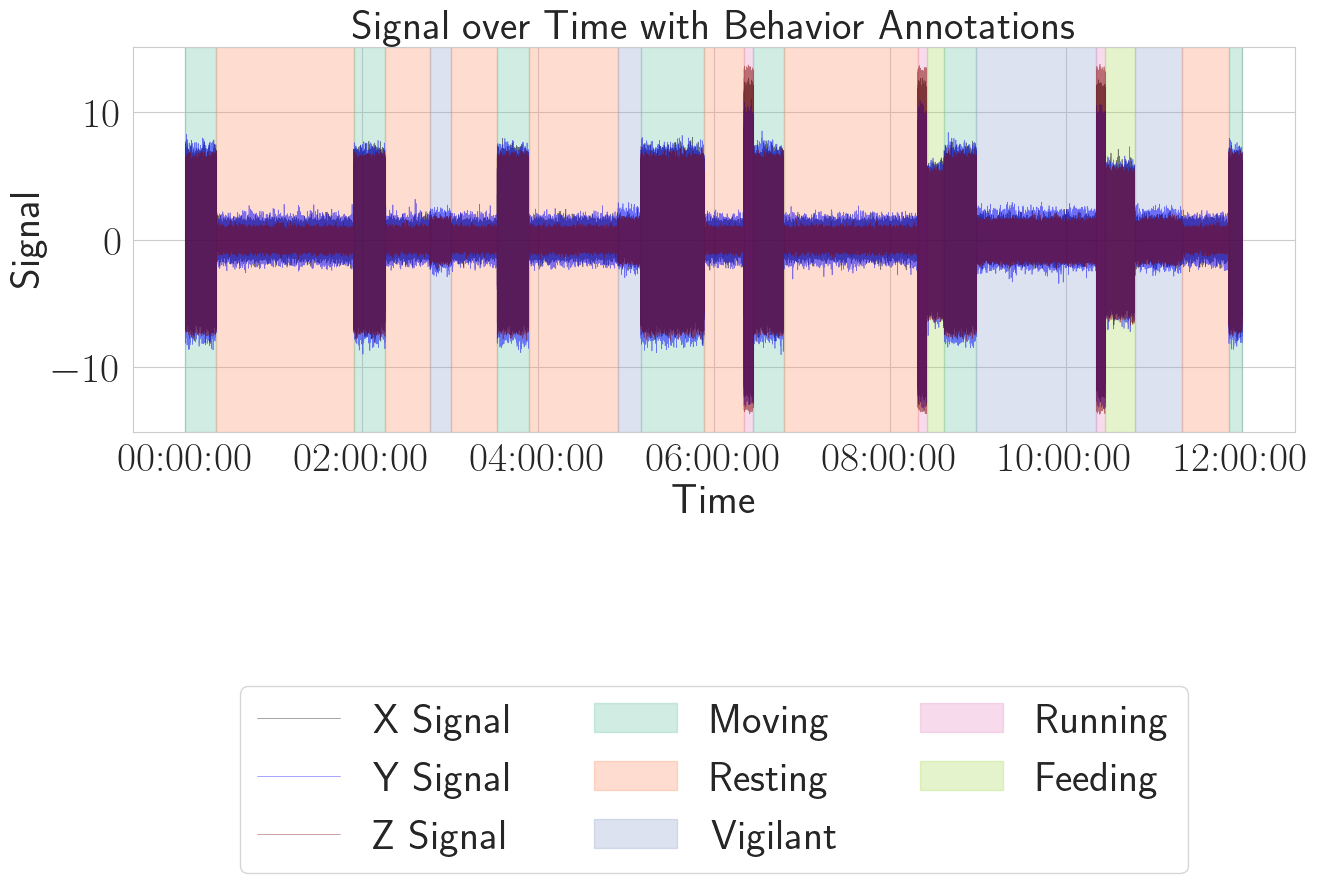

In [34]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Ensure timestamp is datetime
acc_df['Timestamp'] = pd.to_datetime(acc_df['Timestamp'])

# Plot signal
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(acc_df['Timestamp'], acc_df['Acc X [g]'], label='X Signal', color='black', linewidth=.5, alpha=0.5)
ax.plot(acc_df['Timestamp'], acc_df['Acc Y [g]'], label='Y Signal', color='blue', linewidth=.5, alpha=0.5)
ax.plot(acc_df['Timestamp'], acc_df['Acc Z [g]'], label='Z Signal', color='maroon', linewidth=.5, alpha=0.5)


# Get start and end indices for each behavior block
acc_df['behavior_shift'] = acc_df['Behavior'].shift()
acc_df['change'] = acc_df['Behavior'] != acc_df['behavior_shift']
change_indices = acc_df.index[acc_df['change']].tolist() + [acc_df.index[-1] + 1]

# Pick distinct colors for behaviors
import seaborn as sns
colors = dict(zip(acc_df['Behavior'].unique(), sns.color_palette("Set2", acc_df['Behavior'].nunique())))

# Mark regions using axvspan
for start_idx, end_idx in zip(change_indices[:-1], change_indices[1:]):
    row = acc_df.iloc[start_idx]
    behavior = row['Behavior']
    color = colors[behavior]
    ax.axvspan(acc_df.loc[start_idx, 'Timestamp'], acc_df.loc[end_idx - 1, 'Timestamp'],
               alpha=0.3, color=color, label=behavior)

# Format x-axis and legend
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
ax.set_xlabel('Time')
ax.set_ylabel('Signal')
ax.set_title('Signal over Time with Behavior Annotations')

# To avoid duplicate labels in legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc='lower center', ncol=3, bbox_to_anchor=(0.5, -1.2))

plt.tight_layout()
plt.show()


/home/medhaaga/AWD-Biologging/notebooks/../src/utils/plot.py:296: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 2.9, 1])  # Reduce right space for colorbar


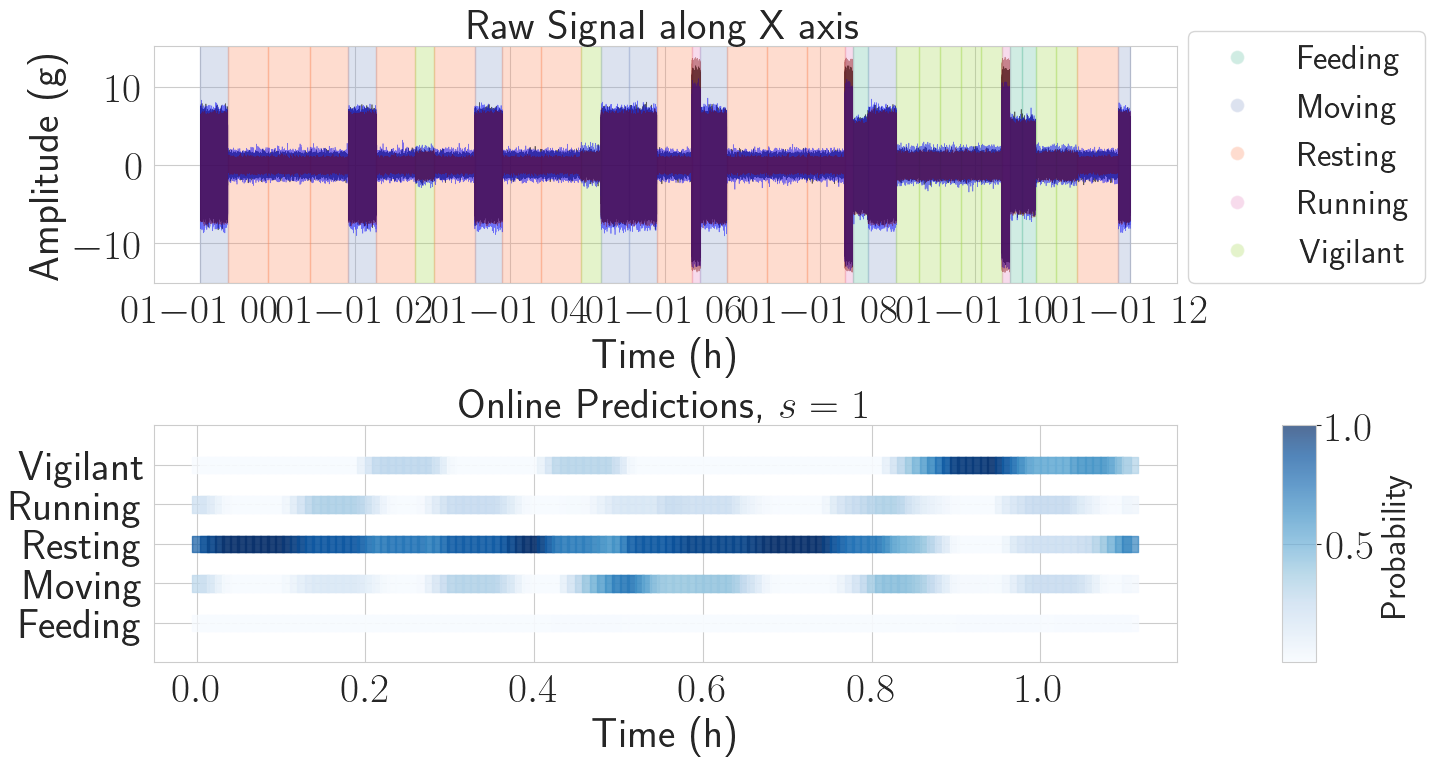

(<Figure size 1500x800 with 3 Axes>,
 (<Axes: title={'center': 'Raw Signal along X axis'}, xlabel='Time (h)', ylabel='Amplitude (g)'>,
  <Axes: title={'center': 'Online Predictions, $s = 1$'}, xlabel='Time (h)'>))

In [35]:
smoothening_config = {'smoothening_window_length': 1,
                          'smoothening_hop_length': 1,
                          'score_hop_length': None
                          }

plot_signal_and_online_predictions(
    acc_df['Timestamp'],
    signal, 
    online_avg, 
    smoothening_config['smoothening_window_length'], 
    smoothening_config['smoothening_hop_length'], 
    window_duration, 
    label_encoder, 
    sampling_rate=config.SAMPLING_RATE, 
    plot_dir=None,
    half_day_behaviors=half_day_behaviors
)

/home/medhaaga/AWD-Biologging/notebooks/../src/utils/plot.py:296: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 2.9, 1])  # Reduce right space for colorbar


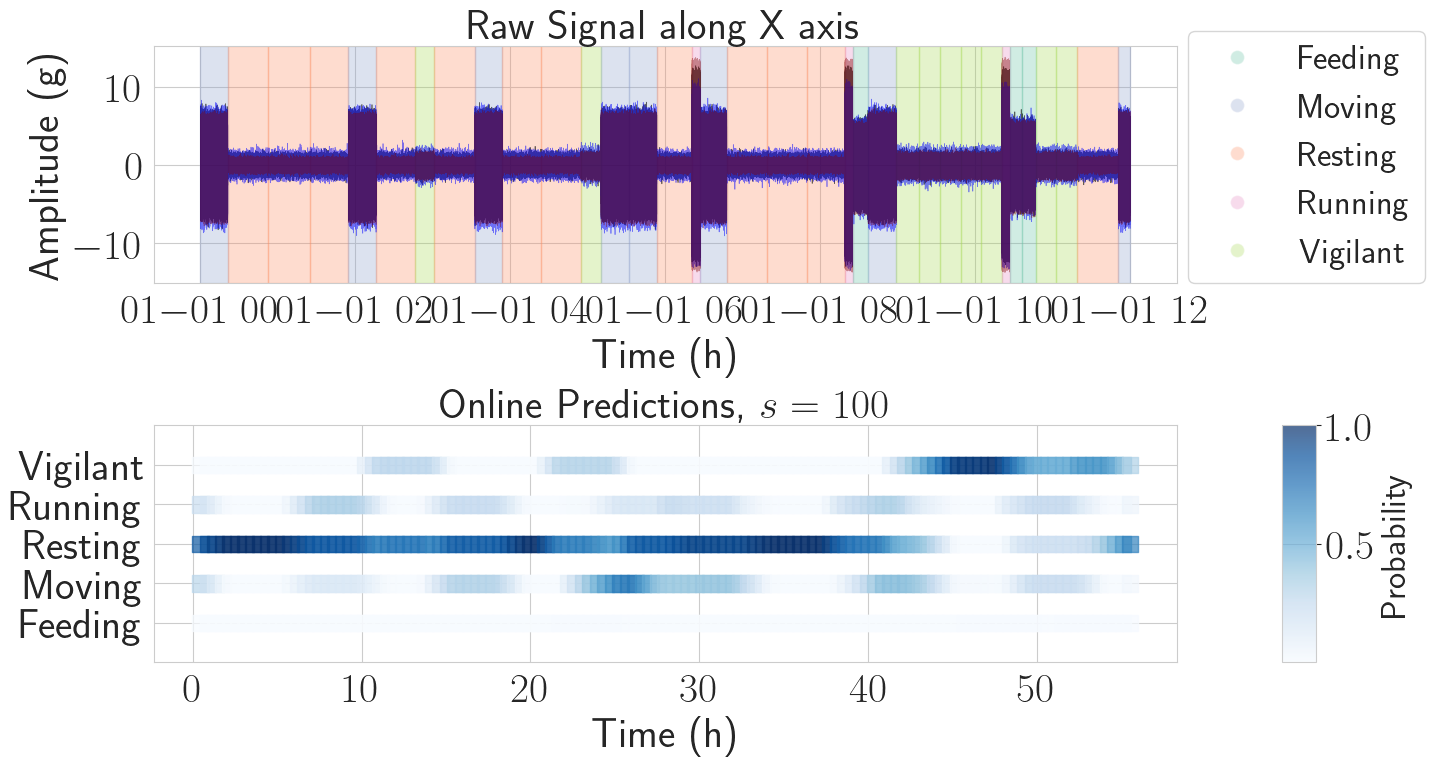

(<Figure size 1500x800 with 3 Axes>,
 (<Axes: title={'center': 'Raw Signal along X axis'}, xlabel='Time (h)', ylabel='Amplitude (g)'>,
  <Axes: title={'center': 'Online Predictions, $s = 100$'}, xlabel='Time (h)'>))

In [36]:
smoothening_config = {'smoothening_window_length': 100,
                          'smoothening_hop_length': 50,
                          'score_hop_length': None
                          }

plot_signal_and_online_predictions(
    acc_df['Timestamp'],
    signal, 
    online_avg, 
    smoothening_config['smoothening_window_length'], 
    smoothening_config['smoothening_hop_length'], 
    window_duration, 
    label_encoder, 
    sampling_rate=config.SAMPLING_RATE, 
    plot_dir=None,
    half_day_behaviors=half_day_behaviors
)

## Distribution Shift

In [37]:
# experiment paths

results_dir = os.path.join(config.TEST_ROOT_DIR, "distribution_shift")
os.makedirs(results_dir, exist_ok=True)
# define paths for various objects for this result subsection
annotations_path = results_dir+"/test_all_annotations.csv"
metadata_path = results_dir+"/test_metadata.csv"
data_path = os.path.join(results_dir, "data")
os.makedirs(data_path, exist_ok=True)
training_results_dir = os.path.join(results_dir, "training_results")
os.makedirs(training_results_dir, exist_ok=True)

matched_summary_path = data_path+"/matched_acc_summary.csv"
matched_data_path = data_path+"/matched_acc_data.csv"
matched_metadata_path = data_path+"/matched_acc_metadata.csv"

In [38]:

young_data_constants = [
    # Resting — make it slightly jittery to overlap with Vigilant
    ("Resting", "X", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),
    ("Resting", "Y", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),
    ("Resting", "Z", (0.2, 0.3, 0.4), (0.1, 0.15, 0.1), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),

    # Vigilant — lower the amplitude and raise noise to blur with Resting
    ("Vigilant", "X", (0.3, 0.5, 0.8), (0.2, 0.3, 0.4), (0.0, 0.3, 0.6), (0.2, 0.25, 0.3)),
    ("Vigilant", "Y", (0.4, 0.6, 0.9), (0.3, 0.4, 0.5), (0.0, 0.4, 0.8), (0.2, 0.25, 0.3)),
    ("Vigilant", "Z", (0.4, 0.6, 1.0), (0.8, 0.9, 0.6), (0.0, 0.5, 1.0), (0.2, 0.25, 0.3)),

    # Feeding — bring down the amplitude and overlap with Moving
    ("Feeding", "X", (1.8, 1.5, 2.2), (1.5, 1.8, 1.1), (0.2, 0.7, 1.2), (0.3, 0.35, 0.4)),
    ("Feeding", "Y", (1.0, 1.8, 2.5), (1.6, 1.4, 1.2), (0.3, 0.8, 1.3), (0.3, 0.35, 0.4)),
    ("Feeding", "Z", (1.2, 1.9, 2.7), (1.7, 1.0, 1.3), (0.4, 0.9, 1.4), (0.3, 0.35, 0.4)),

    # Moving — slightly reduce amplitude, overlap more with Feeding
    ("Moving", "X", (2.5, 3.2, 3.0), (2.0, 2.3, 2.5), (0.6, 1.2, 1.8), (0.35, 0.4, 0.45)),
    ("Moving", "Y", (2.8, 3.5, 3.2), (2.1, 2.4, 2.6), (0.5, 1.0, 1.5), (0.35, 0.4, 0.45)),
    ("Moving", "Z", (3.0, 3.8, 3.5), (2.0, 2.5, 2.7), (0.7, 1.2, 1.8), (0.35, 0.4, 0.45)),

    # Running — keep it distinct, but increase overlap with upper Moving
    ("Running", "X", (4.5, 5.5, 6.5), (3.8, 3.2, 3.5), (0.6, 1.0, 1.4), (0.4, 0.5, 0.6)),
    ("Running", "Y", (4.0, 5.0, 5.0), (3.5, 3.0, 3.5), (0.4, 0.9, 1.5), (0.4, 0.5, 0.6)),
    ("Running", "Z", (4.5, 5.5, 5.5), (2.8, 3.3, 3.0), (0.7, 1.1, 1.6), (0.4, 0.5, 0.6)),
]

adult_data_constants = [
    # Resting — make it slightly jittery to overlap with Vigilant
    ("Resting", "X", (0.2, 0.3, 0.4), (0.1, 0.15, 0.2), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),
    ("Resting", "Y", (0.2, 0.3, 0.4), (0.1, 0.15, 0.2), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),
    ("Resting", "Z", (0.2, 0.3, 0.4), (0.1, 0.15, 0.2), (0.0, 0.1, 0.2), (0.15, 0.2, 0.25)),

    # Vigilant — lower the amplitude and raise noise to blur with Resting
    ("Vigilant", "X", (0.3, 0.5, 0.8), (1.2, 0.3, 1.4), (0.0, 0.3, 0.6), (0.2, 0.25, 0.3)),
    ("Vigilant", "Y", (0.4, 0.6, 0.9), (1.3, 0.4, 1.5), (0.0, 0.4, 0.8), (0.2, 0.25, 0.3)),
    ("Vigilant", "Z", (0.4, 0.6, 1.0), (1.3, 0.5, 1.6), (0.0, 0.5, 1.0), (0.2, 0.25, 0.3)),

    # Feeding — bring down the amplitude and overlap with Moving
    ("Feeding", "X", (1.8, 2.5, 3.2), (2.9, 2.8, 2.1), (0.2, 0.7, 1.2), (0.3, 0.35, 0.4)),
    ("Feeding", "Y", (2.0, 2.8, 3.5), (2.6, 2.9, 2.2), (0.3, 0.8, 1.3), (0.3, 0.35, 0.4)),
    ("Feeding", "Z", (2.2, 2.9, 3.7), (2.7, 2.9, 2.3), (0.4, 0.9, 1.4), (0.3, 0.35, 0.4)),

    # Moving — slightly reduce amplitude, overlap more with Feeding
    ("Moving", "X", (2.5, 3.2, 4.0), (3.0, 2.3, 2.5), (0.6, 1.2, 1.8), (0.35, 0.4, 0.45)),
    ("Moving", "Y", (2.8, 3.5, 4.2), (2.1, 3.4, 2.6), (0.5, 1.0, 1.5), (0.35, 0.4, 0.45)),
    ("Moving", "Z", (3.0, 3.8, 4.5), (2.0, 3.5, 2.7), (0.7, 1.2, 1.8), (0.35, 0.4, 0.45)),

    # Running — keep it distinct, but increase overlap with upper Moving
    ("Running", "X", (5.5, 6.5, 7.5), (4.8, 4.2, 4.5), (0.6, 1.0, 1.4), (0.4, 0.5, 0.6)),
    ("Running", "Y", (5.0, 6.0, 7.0), (4.5, 4.0, 4.5), (0.4, 0.9, 1.5), (0.4, 0.5, 0.6)),
    ("Running", "Z", (5.5, 6.5, 7.5), (3.8, 4.3, 5.0), (0.7, 1.1, 1.6), (0.4, 0.5, 0.6)),
]

young_data_constants = pd.DataFrame(young_data_constants, columns=[
    "Behavior", "Axis", "f", "A", "phi", "sigma"
])

adult_data_constants = pd.DataFrame(adult_data_constants, columns=[
    "Behavior", "Axis", "f", "A", "phi", "sigma"
])

In [39]:
# Define individuals and years of dataset available for them
young_individuals = {"individual1": [2022],
               "individual2": [2022],
               "individual3": [2022]}

adult_individuals = {"individual1": [2025],
               "individual2": [2025],
               "individual3": [2025]}

behavior_prob = [0.1, 0.4, 0.2, 0.1, 0.2]

print("CLASS DISTRIBUTION")
for b, p in zip(config.BEHAVIORS, behavior_prob):
    print(f"{b:<10}: {p}")


CLASS DISTRIBUTION
Feeding   : 0.1
Resting   : 0.4
Moving    : 0.2
Running   : 0.1
Vigilant  : 0.2


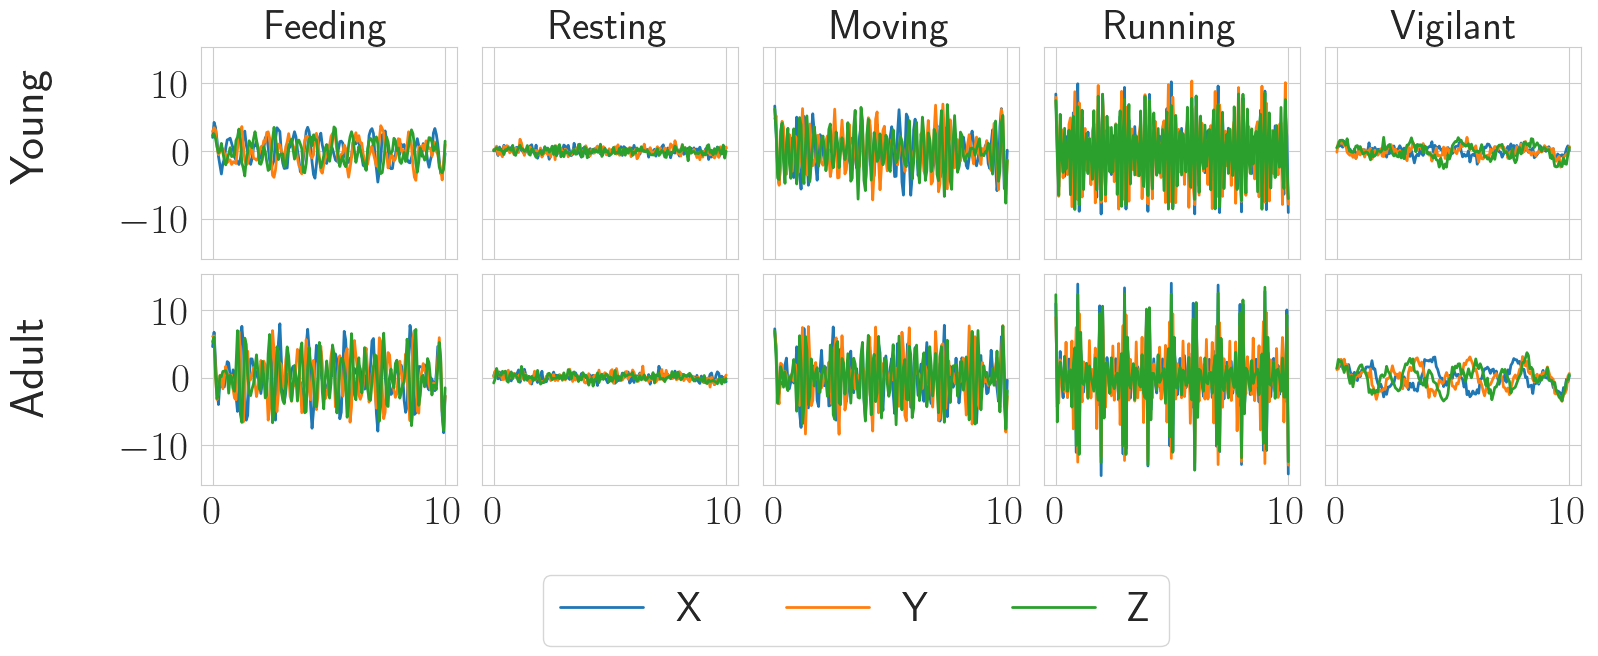

In [40]:
t = np.linspace(0, 10, 160)
fig, axs = plt.subplots(2, 5, figsize=(15, 6), sharey=True, sharex=True)

for i, observed_behavior in enumerate(config.BEHAVIORS):

    # Young individuals
    f_X, A_X, phi_X = young_data_constants.loc[(young_data_constants["Behavior"] == observed_behavior) & (young_data_constants["Axis"] == "X"), ['f', 'A', 'phi']].values[0]
    f_Y, A_Y, phi_Y = young_data_constants.loc[(young_data_constants["Behavior"] == observed_behavior) & (young_data_constants["Axis"] == "Y"), ['f', 'A', 'phi']].values[0]
    f_Z, A_Z, phi_Z = young_data_constants.loc[(young_data_constants["Behavior"] == observed_behavior) & (young_data_constants["Axis"] == "Z"), ['f', 'A', 'phi']].values[0]

    signal_x = simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_y = simulate_fourier_signal(list(f_Y), list(A_Y), list(phi_Y), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_z = simulate_fourier_signal(list(f_Z), list(A_Z), list(phi_Z), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))

    axs[0, i].plot(t, signal_x)
    axs[0, i].plot(t, signal_y)
    axs[0, i].plot(t, signal_z)
    axs[0, i].set_title(observed_behavior)

    # Adult individuals
    f_X, A_X, phi_X = adult_data_constants.loc[(adult_data_constants["Behavior"] == observed_behavior) & (adult_data_constants["Axis"] == "X"), ['f', 'A', 'phi']].values[0]
    f_Y, A_Y, phi_Y = adult_data_constants.loc[(adult_data_constants["Behavior"] == observed_behavior) & (adult_data_constants["Axis"] == "Y"), ['f', 'A', 'phi']].values[0]
    f_Z, A_Z, phi_Z = adult_data_constants.loc[(adult_data_constants["Behavior"] == observed_behavior) & (adult_data_constants["Axis"] == "Z"), ['f', 'A', 'phi']].values[0]

    signal_x = simulate_fourier_signal(list(f_X), list(A_X), list(phi_X), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_y = simulate_fourier_signal(list(f_Y), list(A_Y), list(phi_Y), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))
    signal_z = simulate_fourier_signal(list(f_Z), list(A_Z), list(phi_Z), len(t), config.SAMPLING_RATE) + np.random.normal(loc=0, scale=0.5, size=len(t))

    if i == 0:
        axs[1, i].plot(t, signal_x, label='X')
        axs[1, i].plot(t, signal_y, label='Y')
        axs[1, i].plot(t, signal_z, label='Z')
    else:
        axs[1, i].plot(t, signal_x)
        axs[1, i].plot(t, signal_y)
        axs[1, i].plot(t, signal_z)

fig.text(-0.05, 0.7, 'Young', ha='center', va='center', fontsize=34, fontweight='bold', rotation=90)
fig.text(-0.05, 0.3, 'Adult', ha='center', va='center', fontsize=34, fontweight='bold', rotation=90)

fig.legend(loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.2))
plt.tight_layout(rect=[0, 0, 1, 0.92])  # Leave space at the top for titles
plt.show()


In [61]:
generate_acc_data(young_individuals, results_dir, behavior_prob, young_data_constants)
generate_acc_data(adult_individuals, results_dir, behavior_prob, data_constants)

100%|██████████| 3/3 [01:20<00:00, 26.92s/it]


In [ ]:
individuals = [f"individual{i}" for i in range(1, 4)]
test_paths = {ind: f"{results_dir}/{ind}" for ind in individuals}

# create halfday segments
create_segments_and_metadata.run_vectronics(test_paths, max_chunks=5)

# create metadata
create_segments_and_metadata.create_metadata(test_paths, metadata_path)


In [63]:

# load metadata and annotations
metadata = pd.read_csv(metadata_path)
all_annotations = pd.read_csv(annotations_path)

# match acc and behvaior
acc_summary, acc_data, acc_data_metadata = create_matched_data_objects.create_matched_data(metadata, all_annotations)
acc_summary.to_csv(matched_summary_path)
acc_data.to_csv(matched_data_path)
acc_data_metadata.to_csv(matched_metadata_path)

individual individual1 has 4 halfdays in the filtered metadata.


Processing unique half days for individual1: 100%|██████████| 4/4 [00:21<00:00,  5.25s/it]


individual individual2 has 4 halfdays in the filtered metadata.


Processing unique half days for individual2: 100%|██████████| 4/4 [00:20<00:00,  5.16s/it]


individual individual3 has 4 halfdays in the filtered metadata.


Processing unique half days for individual3: 100%|██████████| 4/4 [00:20<00:00,  5.15s/it]


In [41]:
# load metadata and annotations
metadata = pd.read_csv(metadata_path)
all_annotations = pd.read_csv(annotations_path)

# load the saved matched data objects 
acc_summary = pd.read_csv(matched_summary_path)
acc_data = pd.read_csv(matched_data_path)
acc_data_metadata = pd.read_csv(matched_metadata_path)

In [42]:

@dataclass
class Arguments:
    experiment_name: str
    batch_size: int
    window_duration_percentile: float
    train_test_split: float
    train_val_split: float
    padding: str
    theta: float
    filter_type: str
    cutoff_frequency: float
    cutoff_order: int
    normalization: int
    match: int
    min_duration: float
    n_CNNlayers: int
    n_channels: int
    kernel_size: int
    learning_rate: float
    weight_decay: float
    num_epochs: int
    alpha: float
    verbose: int

args = Arguments(
    experiment_name='no_split', batch_size=64, window_duration_percentile=20, 
    train_test_split=0.2, train_val_split=0.2, padding='repeat', theta=0.0, 
    filter_type='high', cutoff_frequency=0, cutoff_order=5, normalization=0,
    match=0, min_duration=1.0, n_CNNlayers=5, n_channels=16, kernel_size=5,
    learning_rate=0.0001, weight_decay=0.0001, num_epochs=500, alpha=0.05, verbose=0
)


In [43]:
args.experiment_name = 'test_interyear'
args.theta= 0.8

train_filter_profile, test_filter_profile = utils_data.get_exp_filter_profiles(args.experiment_name)

print('INTERYEAR')
print(f"{'train filter':<15} {train_filter_profile}")
print(f"{'test filter':<15} {test_filter_profile}")

INTERYEAR
train filter    {'individual ID': None, 'year': [2022], 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}
test filter     {'individual ID': None, 'year': [2025], 'UTC Date [yyyy-mm-dd]': None, 'am/pm': None, 'half day [yyyy-mm-dd_am/pm]': None, 'avg temperature [C]': None}


In [44]:

start = time.time()
X_train, y_train, z_train, X_val, y_val, z_val, X_test, y_test, z_test, _ = utils_data.setup_data_objects(metadata=metadata, 
                                                                                                    all_annotations=all_annotations, 
                                                                                                    collapse_behavior_mapping=config.COLLAPSE_BEHAVIORS_MAPPING, 
                                                                                                    behaviors=config.BEHAVIORS, 
                                                                                                    args=args, 
                                                                                                    reuse_behaviors=config.BEHAVIORS,
                                                                                                    acc_data_path=matched_data_path,
                                                                                                    acc_metadata_path=matched_metadata_path
                                                                                                    )
n_timesteps, n_features, n_outputs = X_train.shape[2], X_train.shape[1], len(np.unique(np.concatenate((y_train, y_val, y_test))))

print("Train Class distribution")
print("==========================")
print(pd.DataFrame(np.unique(y_train, return_counts=True)[1]))
print("")

time_diff = time.time() - start

print("")
print(f'Creating data objects takes {time_diff:.2f} seconds.')
print("")
print("Shape of dataframes")
print("==========================")
print(f"{'Set':<8} {'X':<15} {'Y':<10} {'Z':<15}")
print(f"{'Train:':<8} {str(X_train.shape):<15} {str(y_train.shape):<10} {str(z_train.shape):<15}")
print(f"{'Val:':<8} {str(X_val.shape):<15} {str(y_val.shape):<10} {str(z_val.shape):<15}")
print(f"{'Test:':<8} {str(X_test.shape):<15} {str(y_test.shape):<10} {str(z_test.shape):<15}")

Using pre-matched acceleration-behavior pairs...
Total number of matched annotations: 201
No overlaps. 
no. of train observations: 101, no. of test observations: 100

Matching annotations to acceleration snippets takes 4.472473 seconds
Creating fixed-duration windows takes 1.410868 seconds.

Time series duration window = 17.0
Train Class distribution
     0
0   83
1  103
2  293
3   39
4  174


Creating data objects takes 5.91 seconds.

Shape of dataframes
Set      X               Y          Z              
Train:   (692, 3, 272)   (692,)     (692, 7)       
Val:     (174, 3, 272)   (174,)     (174, 7)       
Test:    (774, 3, 272)   (774,)     (774, 7)       


In [45]:
train_dataloader, val_dataloader, test_dataloader = utils_data.setup_multilabel_dataloaders(X_train, y_train, X_val, y_val, X_test, y_test, args)
device = torch.device(f"cuda:{0}" if torch.cuda.is_available() else "cpu")

# Define the sequential model
model = create_dynamic_conv_model(n_features, n_timesteps, n_outputs, 
                                        num_conv_layers=args.n_CNNlayers, 
                                        base_channels=args.n_channels, 
                                        kernel_size=args.kernel_size).to(device)

print("")
print("==================================")
print(f"Number of trainable model paramters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

#########################################
#### Training
#########################################

train_obj = train_run(model, optimizer, criterion, train_dataloader, val_dataloader, test_dataloader, args, device)
model = train_obj['model']
training_stats = train_obj['training_stats']

dir = os.path.join(training_results_dir, f"theta{args.theta}")
os.makedirs(dir, exist_ok=True)
torch.save(model, os.path.join(dir, 'model.pt'))
json_training_stats_file = os.path.join(dir, 'training_stats.json')
with open(json_training_stats_file, 'w') as f:
    json.dump(training_stats, f)


# save true and predicted test classes along with test metadata
np.save(os.path.join(dir, 'test_true_classes.npy'), train_obj['test_true_classes'])
np.save(os.path.join(dir, 'test_predictions.npy'),  train_obj['test_predictions'])
np.save(os.path.join(dir, 'test_scores.npy'),  train_obj['test_scores'])

# save true and predicted validation classes along with val metadata
np.save(os.path.join(dir, 'val_true_classes.npy'),  train_obj['val_true_classes'])
np.save(os.path.join(dir, 'val_predictions.npy'),  train_obj['val_predictions'])
np.save(os.path.join(dir, 'val_scores.npy'),  train_obj['val_scores'])




Number of trainable model paramters: 228581


Epoch 500/500 | Train Loss: 0.0003 | Val Loss: 0.0004: 100%|██████████| 500/500 [00:44<00:00, 11.21it/s]


Total training time: 0:00:45


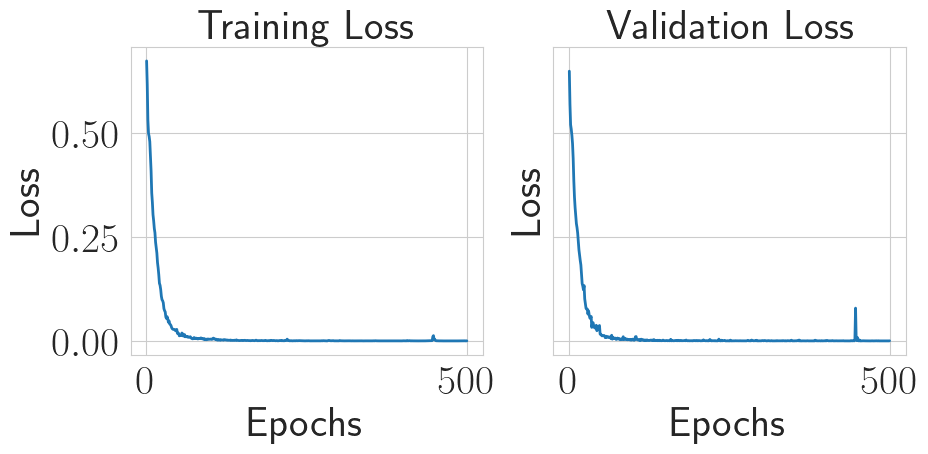

In [46]:
#plot training stats
training_stats = pd.DataFrame(training_stats)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axs[0].plot(training_stats['epoch'], training_stats['Training Loss'])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].set_title("Training Loss")

axs[1].plot(training_stats['epoch'], training_stats['Validation Loss'])
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].set_title("Validation Loss")
plt.show()

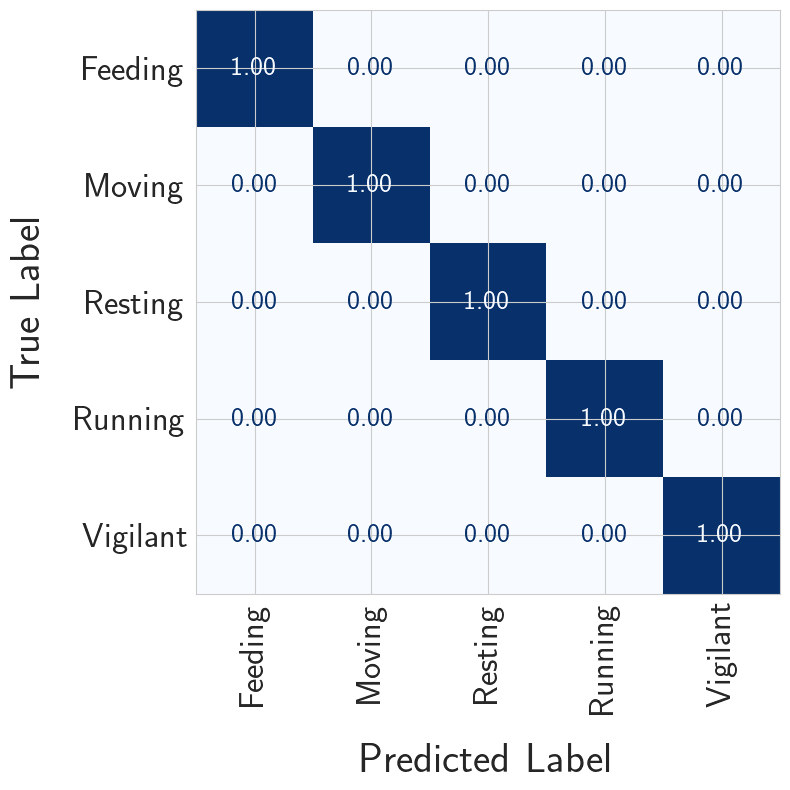

In [50]:
dir = os.path.join(training_results_dir, f"theta0.8")
label_encoder = LabelEncoder()
label_encoder.fit(config.BEHAVIORS)

multi_label_predictions(dir, label_encoder, split='val', plot_confusion=True, return_accuracy=False, plot_path=None)

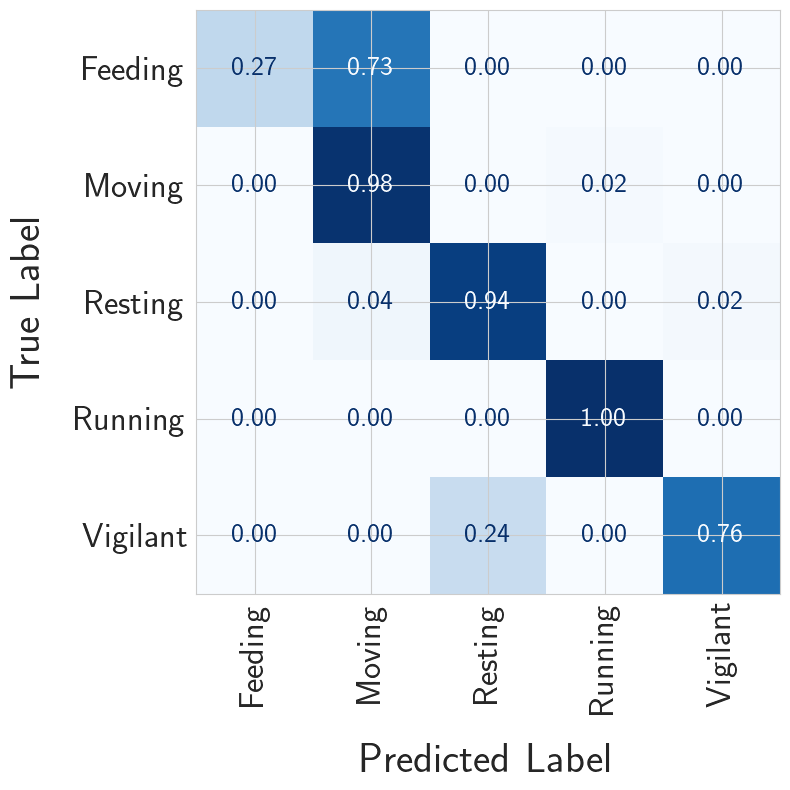

In [51]:
multi_label_predictions(dir, label_encoder, split='test', plot_confusion=True, return_accuracy=False, plot_path=None)

In [55]:
dir = os.path.join(training_results_dir, f"theta0.8")

print("VALIDATION SET")
print("")

print('VAL PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': config.BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True, average=None), 3)}))

print('VAL RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': config.BEHAVIORS, 'recall': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True, average=None), 3)}))

print('VAL F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': config.BEHAVIORS, 'f1 score': np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True, average=None), 3)}))

print('VAL ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

VALIDATION SET

VAL PRECISION SCORE
---------------------
Average precision: 1.0
   behavior  precision
0   Feeding        1.0
1   Resting        1.0
2    Moving        1.0
3   Running        1.0
4  Vigilant        1.0
VAL RECALL SCORE
---------------------
Average recall: 1.0
   behavior  recall
0   Feeding     1.0
1   Resting     1.0
2    Moving     1.0
3   Running     1.0
4  Vigilant     1.0
VAL F1 SCORE
---------------------
Average F1 score: 1.0
   behavior  f1 score
0   Feeding       1.0
1   Resting       1.0
2    Moving       1.0
3   Running       1.0
4  Vigilant       1.0
VAL ACCURACY
---------------------
Accuracy: 1.0


In [56]:
print("TEST SET")
print("")


print('TEST PRECISION SCORE')
print('---------------------')
precision = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average='macro'), 3)
print(f'Average precision: {precision}')
print(pd.DataFrame({'behavior': config.BEHAVIORS, 'precision': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_precision=True, average=None), 3)}))

print('TEST RECALL SCORE')
print('---------------------')
recall = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average='macro'), 3)
print(f'Average recall: {recall}')
print(pd.DataFrame({'behavior': config.BEHAVIORS, 'recall': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_recall=True, average=None), 3)}))

print('TEST F1 SCORE')
print('---------------------')
f1 = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average='macro'), 3)
print(f'Average F1 score: {f1}')
print(pd.DataFrame({'behavior': config.BEHAVIORS, 'f1 score': np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_f1=True, average=None), 3)}))

print('TEST ACCURACY')
print('---------------------')
accuracy = np.round(multi_label_predictions(dir, label_encoder, split='test', plot_confusion=False, return_accuracy=True), 3)
print(f'Accuracy: {accuracy}')

TEST SET

TEST PRECISION SCORE
---------------------
Average precision: 0.903
   behavior  precision
0   Feeding      1.000
1   Resting      0.707
2    Moving      0.890
3   Running      0.969
4  Vigilant      0.949
TEST RECALL SCORE
---------------------
Average recall: 0.791
   behavior  recall
0   Feeding   0.268
1   Resting   0.985
2    Moving   0.943
3   Running   1.000
4  Vigilant   0.760
TEST F1 SCORE
---------------------
Average F1 score: 0.798
   behavior  f1 score
0   Feeding     0.423
1   Resting     0.823
2    Moving     0.916
3   Running     0.984
4  Vigilant     0.844
TEST ACCURACY
---------------------
Accuracy: 0.866
